In [ ]:
#Emptying the Cache memory present in the CUDA
import torch
torch.cuda.empty_cache()

## Importing the necessary packages and initialising various parameters ##
import torch
import os
from torch.utils.data import Dataset
import cv2
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.io import imread, imsave
from skimage.transform import resize
import torchvision
import torchvision.transforms.functional as G
from google.colab.patches import cv2_imshow
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils import model_zoo
from torchvision import models
from torch.optim.lr_scheduler import StepLR

# Initializing learning rate, number of epochs to train and the batch size
Learning_rate= 0.001
Number_of_epochs = 20
Batch_size = 4

#Input image dimensions
Input_image_width = 650
Input_image_height = 650


#Define the test split
Test_split= 0.15

#Determine the device to be used for training and evaluation
Device= "cuda" if torch.cuda.is_available() else "cpu"
print(Device)

cuda


In [ ]:
## Dataset loading ##


# Transformations of the image to desired size and convert to tensor
transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((520,520)),transforms.ToTensor()]) #,transforms.Normalize(mean=56.7323,std=77.3947)


class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		imagePath = self.imagePaths[idx]  # grab the image path from the current index
		maskPath=self.maskPaths[idx]
		image = cv2.imread(imagePath,0)
		mask = cv2.imread(maskPath,0)
		image=image*(1/255)
		mask= np.where(mask>128,1,0) # integer
		mask=mask*(1.0) # float
		mask= torch.from_numpy(mask)
		image = torch.from_numpy(image)
	 # check to see if we are applying any transformations
		if self.transforms is not None:
			image = self.transforms(image) # apply the transformations to both image and its mask
			mask = self.transforms(mask)
		return (image, mask)


# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Image')))
maskPaths = sorted(list(paths.list_images('/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Mask')))
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,test_size=0.15, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]


# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,batch_size=Batch_size,num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,batch_size=Batch_size,num_workers=os.cpu_count())

[INFO] found 249 examples in the training set...
[INFO] found 44 examples in the test set...


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits=torch.sigmoid(logits)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)


class DiceLoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1-(2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice_loss

class IoULoss(Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [ ]:
## Running the Model ##

#For calculating the average loss 
trainSteps = len(trainDS) // Batch_size
testSteps = len(testDS) // Batch_size
# Initializing the UNet model
UNet = UNet(1,1).to(Device)
# Initializing Loss function and Optimizer
DiceFunc=DiceLoss()
IoUFunc=IoULoss()
optimizer = Adam(UNet.parameters(), lr=Learning_rate)
#scheduler = StepLR(optimizer,step_size = 4, # Period of learning rate decay
                               #gamma = 0.5) # Multiplicative factor of learning rate decay
# initialize a dictionary to store training history
H = {"Dice_Loss": [] , "IOU_Loss": []}
print("Training the network...")
startTime = time.time()


for e in tqdm(range(Number_of_epochs)):
  UNet.train()
  Total_Train_Dice_Loss=0
  Total_Test_Dice_Loss=0
  Total_IoU_Loss=0
  for (i, (x, y)) in enumerate(trainLoader):
    (x, y) = (x.to(Device), y.to(Device))
    prediction = UNet(x)
    Train_Dice_Loss=DiceFunc(prediction,y)
    IoU_Loss=IoUFunc(prediction,y)
    Total_IoU_Loss+=IoU_Loss
    Total_Train_Dice_Loss+=Train_Dice_Loss
    optimizer.zero_grad()
    Train_Dice_Loss.backward()
    optimizer.step()
    #scheduler.step()

  with torch.no_grad():
    UNet.eval()
    for (x, y) in testLoader:
      (x, y) = (x.to(Device), y.to(Device))
      pred = UNet(x)
      Test_Dice_Loss=0
      Test_Dice_Loss=DiceFunc(pred,y)
      Total_Test_Dice_Loss+=Test_Dice_Loss

  avgTrainLoss = Total_Train_Dice_Loss / trainSteps
  avgTestLoss = Total_Test_Dice_Loss / testSteps
  avgIoULoss=Total_IoU_Loss /trainSteps
   
	# update our training history
  H["Dice_Loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["IOU_Loss"].append(avgIoULoss.cpu().detach().numpy())
  # print the model training and validation information
  print("Epoch: {}/{}".format(e + 1, Number_of_epochs))
  print("Train Dice Loss: {:.4f}, Test Dice Loss: {:.4f}, IOU Loss: {:.4f} ".format(avgTrainLoss,avgTestLoss,avgIoULoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

Training the network...


  5%|▌         | 1/20 [01:15<23:48, 75.16s/it]

Epoch: 1/20
Train Dice Loss: 0.9686, Test Dice Loss: 0.9885, IOU Loss: 0.9915 


 10%|█         | 2/20 [02:21<21:00, 70.04s/it]

Epoch: 2/20
Train Dice Loss: 0.9217, Test Dice Loss: 0.9801, IOU Loss: 0.9654 


 15%|█▌        | 3/20 [03:27<19:20, 68.25s/it]

Epoch: 3/20
Train Dice Loss: 0.6765, Test Dice Loss: 0.6142, IOU Loss: 0.7937 


 20%|██        | 4/20 [04:33<17:57, 67.32s/it]

Epoch: 4/20
Train Dice Loss: 0.5412, Test Dice Loss: 0.5581, IOU Loss: 0.6739 


 25%|██▌       | 5/20 [05:39<16:43, 66.91s/it]

Epoch: 5/20
Train Dice Loss: 0.5367, Test Dice Loss: 0.5049, IOU Loss: 0.6784 


 30%|███       | 6/20 [06:45<15:32, 66.62s/it]

Epoch: 6/20
Train Dice Loss: 0.4826, Test Dice Loss: 0.4212, IOU Loss: 0.6275 


 35%|███▌      | 7/20 [07:51<14:23, 66.39s/it]

Epoch: 7/20
Train Dice Loss: 0.6754, Test Dice Loss: 0.9964, IOU Loss: 0.7748 


 40%|████      | 8/20 [08:57<13:15, 66.26s/it]

Epoch: 8/20
Train Dice Loss: 0.7871, Test Dice Loss: 0.7251, IOU Loss: 0.8716 


 45%|████▌     | 9/20 [10:03<12:08, 66.23s/it]

Epoch: 9/20
Train Dice Loss: 0.5361, Test Dice Loss: 0.5470, IOU Loss: 0.6818 


 50%|█████     | 10/20 [11:10<11:01, 66.19s/it]

Epoch: 10/20
Train Dice Loss: 0.4859, Test Dice Loss: 0.4504, IOU Loss: 0.6347 


 55%|█████▌    | 11/20 [12:15<09:55, 66.12s/it]

Epoch: 11/20
Train Dice Loss: 0.4703, Test Dice Loss: 0.4841, IOU Loss: 0.6179 


 60%|██████    | 12/20 [13:22<08:48, 66.12s/it]

Epoch: 12/20
Train Dice Loss: 0.4530, Test Dice Loss: 0.3926, IOU Loss: 0.5991 


 65%|██████▌   | 13/20 [14:28<07:42, 66.10s/it]

Epoch: 13/20
Train Dice Loss: 0.4568, Test Dice Loss: 0.4901, IOU Loss: 0.5968 


 70%|███████   | 14/20 [15:34<06:36, 66.06s/it]

Epoch: 14/20
Train Dice Loss: 0.4246, Test Dice Loss: 0.7814, IOU Loss: 0.5761 


 75%|███████▌  | 15/20 [16:40<05:30, 66.04s/it]

Epoch: 15/20
Train Dice Loss: 0.4320, Test Dice Loss: 0.4027, IOU Loss: 0.5765 


 80%|████████  | 16/20 [17:46<04:24, 66.08s/it]

Epoch: 16/20
Train Dice Loss: 0.3995, Test Dice Loss: 0.4032, IOU Loss: 0.5480 


 85%|████████▌ | 17/20 [18:52<03:18, 66.03s/it]

Epoch: 17/20
Train Dice Loss: 0.4111, Test Dice Loss: 0.4563, IOU Loss: 0.5587 


 90%|█████████ | 18/20 [19:58<02:12, 66.03s/it]

Epoch: 18/20
Train Dice Loss: 0.3999, Test Dice Loss: 0.4300, IOU Loss: 0.5450 


 95%|█████████▌| 19/20 [21:04<01:06, 66.06s/it]

Epoch: 19/20
Train Dice Loss: 0.4158, Test Dice Loss: 0.4170, IOU Loss: 0.5571 


100%|██████████| 20/20 [22:10<00:00, 66.52s/it]

Epoch: 20/20
Train Dice Loss: 0.3891, Test Dice Loss: 0.3897, IOU Loss: 0.5342 
[INFO] total time taken to train the model: 1330.41s


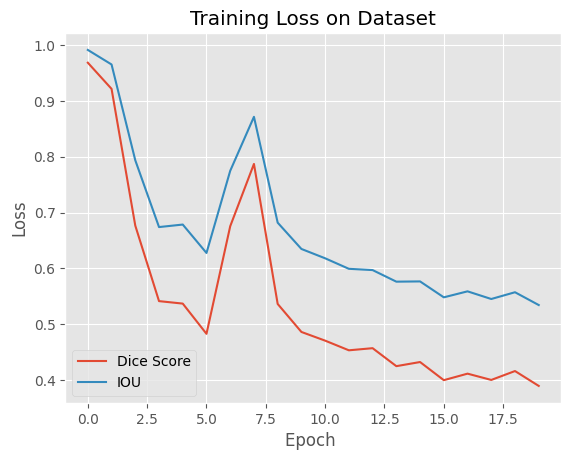

In [ ]:
## Plotting the training loss ##

plt.style.use("ggplot")
plt.figure()
plt.plot(H["Dice_Loss"], label="Dice Score")
plt.plot(H["IOU_Loss"], label="IOU")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [ ]:
#define augmentations 
inference_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((520,520)),transforms.ToTensor()])

#define function for predictions
def predict(model, img, device):
    model.eval()
    with torch.no_grad():
        images = img.to(device)
        output = model(images)
        print('Max=',torch.max(output))
        print('Min=',torch.min(output))
        predicted_masks = (output.squeeze() >= 0.5).float().cpu().numpy()
        
    return(predicted_masks)

#define function to load image and output mask
def get_mask(img_path):
    image = cv2.imread(img_path,0)
    
    image_trans = inference_transform(image)
    image_trans = image_trans.unsqueeze(0)    
    image_mask = predict(UNet, image_trans, Device)
        
    return(image_mask)

Max= tensor(1., device='cuda:0')
Min= tensor(5.5894e-08, device='cuda:0')
Image


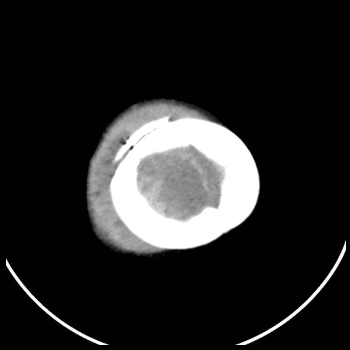

Ground Truth


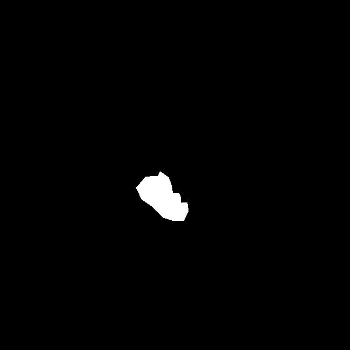

Predicted Mask


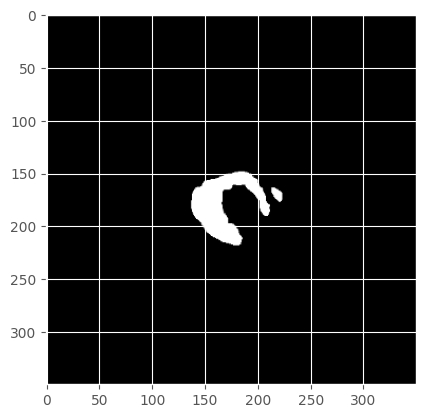

In [ ]:
#image example

Image_path = '/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Image/19.jpg'
Image = cv2.imread(Image_path)
Image = cv2.resize(Image, (350,350))   

Ground_truth_path= '/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Mask/19.jpg'
Ground_truth= cv2.imread(Ground_truth_path)
Ground_truth = cv2.resize(Ground_truth, (350,350))   

predicted_mask = get_mask(Image_path)
predicted_mask = cv2.resize(predicted_mask, (350,350))   

print('Image')
cv2_imshow(Image)

print('Ground Truth')
cv2_imshow(Ground_truth)

print('Predicted Mask')
predicted=np.where(predicted_mask>0.5,1,0)
plt.imshow(predicted_mask,cmap='gray')
#plt.imshow(np.hstack((Image,Ground_truth,predicted_mask)))

Max= tensor(1., device='cuda:0')
Min= tensor(3.4340e-08, device='cuda:0')
Image


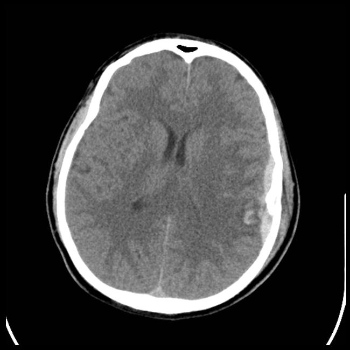

Ground Truth


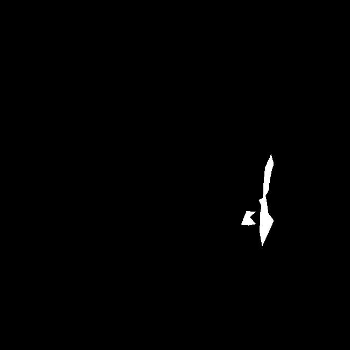

Predicted Mask


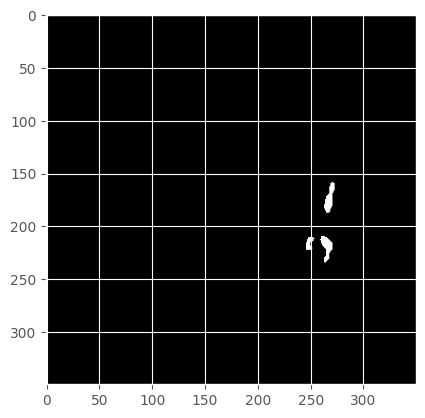

In [ ]:
#image example

Image_path = '/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Image/290.jpg'
Image = cv2.imread(Image_path)
Image = cv2.resize(Image,(350,350))   

Ground_truth_path= '/content/drive/MyDrive/IIIT /Brain_Hemorrage_Dataset/Segmentation/Data/Mask/290.jpg'
Ground_truth= cv2.imread(Ground_truth_path)
Ground_truth = cv2.resize(Ground_truth,(350,350))   

predicted_mask = get_mask(Image_path)
predicted_mask = cv2.resize(predicted_mask,(350,350))   

print('Image')
cv2_imshow(Image)

print('Ground Truth')
cv2_imshow(Ground_truth)

print('Predicted Mask')
predicted=np.where(predicted_mask>0.5,1,0)
plt.imshow(predicted,cmap='gray')